# DL(w8) RNN
student ID: 7110018036\
name: Chieh-An, Chou

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2023-04-25 16:46:09.191738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Predict 10 Step Ahead

## Data (Sequence to Sequence)

In [2]:
def generate_time_series(m, n_seq):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4,m,1)
    time = np.linspace(0,1,n_seq)
    series = 0.5*np.cos((time-offsets1)*(freq1*10+10))
    series+= 0.3*np.sin((time-offsets2)*(freq2*20+20))
    series+= 0.1*(np.random.rand(m, n_seq)-0.5)
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(1)
n_seq = 30
n_pred = 10

series = generate_time_series(5000, n_seq + n_pred)
series.shape

(5000, 40, 1)

In [4]:
x_train = series[:3000, :n_seq]
x_valid = series[3000:4000, :n_seq]
x_test  = series[4000:, :n_seq]

y = np.empty((5000, n_seq, n_pred))
for step_ahead in range(1, n_pred+1):
    y[..., step_ahead-1] = series[..., step_ahead:step_ahead+n_seq, 0]

y_train = y[:3000]
y_valid = y[3000:4000]
y_test  = y[4000:]

x_train.shape, y_train.shape

((3000, 30, 1), (3000, 30, 10))

In [5]:
def plot_seq(x,y,y_pred= None):
    n_seq = x.shape[0]
    ahead = y.shape[0]
    plt.hlines(0,0,n_seq+ahead,linewidth=1, colors='black')
    plt.plot(x, '.-')
    plt.plot(np.arange(n_seq, n_seq+ahead), y, 'go-', label='$y$')  # 'go' = green 'o' 
    if y_pred is not None:
        plt.plot(np.arange(n_seq, n_seq+ahead), y_pred, 'rx-',      # 'rx' = red 'x' 
                 label='$\hat y$', markersize = 10)
    plt.axis([0,n_seq+ahead,-1,1])                                  # seting range of x-axis and y-axis
    plt.grid(True)
    plt.legend(fontsize = 14)

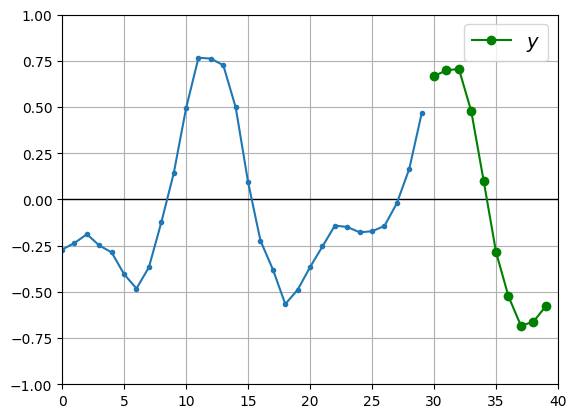

In [6]:
plot_seq(x_test[0,:,0], y_test[0, -1])

## LSTM Cell
### 1. Build Model

In [7]:
np.random.seed(1)
tf.random.set_seed(1)

+ time_distributed: (1+20)*10 (still like dense)

In [8]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]), 
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.summary()

2023-04-25 16:46:10.909884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 16:46:11.252841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7941 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 20)          1760      
                                                                 
 lstm_1 (LSTM)               (None, None, 20)          3280      
                                                                 
 time_distributed (TimeDistr  (None, None, 10)         210       
 ibuted)                                                         
                                                                 
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


### 2. Compile

In [9]:
def last_time_step_mse(y_true, y_pred):
    return keras.metrics.mean_squared_error(y_true[:,-1], y_pred[:,-1])
model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=.01),
              metrics=[last_time_step_mse])

### 3. Train 

In [10]:
train = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20


2023-04-25 17:05:56.261544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
2023-04-25 17:05:56.530595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-25 17:05:56.664135: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fbe8411edb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-25 17:05:56.664151: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-04-25 17:05:56.696830: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-25 17:05:57.039072: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 

94/94 [==============================] - 6s 13ms/step - loss: 0.0998 - last_time_step_mse: 0.0868 - val_loss: 0.0710 - val_last_time_step_mse: 0.0485
Epoch 2/20
94/94 [==============================] - 1s 12ms/step - loss: 0.0637 - last_time_step_mse: 0.0399 - val_loss: 0.0609 - val_last_time_step_mse: 0.0370
Epoch 3/20
94/94 [==============================] - 2s 16ms/step - loss: 0.0570 - last_time_step_mse: 0.0314 - val_loss: 0.0545 - val_last_time_step_mse: 0.0281
Epoch 4/20
94/94 [==============================] - 1s 7ms/step - loss: 0.0540 - last_time_step_mse: 0.0289 - val_loss: 0.0519 - val_last_time_step_mse: 0.0261
Epoch 5/20
94/94 [==============================] - 2s 17ms/step - loss: 0.0504 - last_time_step_mse: 0.0245 - val_loss: 0.0486 - val_last_time_step_mse: 0.0239
Epoch 6/20
94/94 [==============================] - 1s 16ms/step - loss: 0.0450 - last_time_step_mse: 0.0161 - val_loss: 0.0414 - val_last_time_step_mse: 0.0118
Epoch 7/20
94/94 [============================

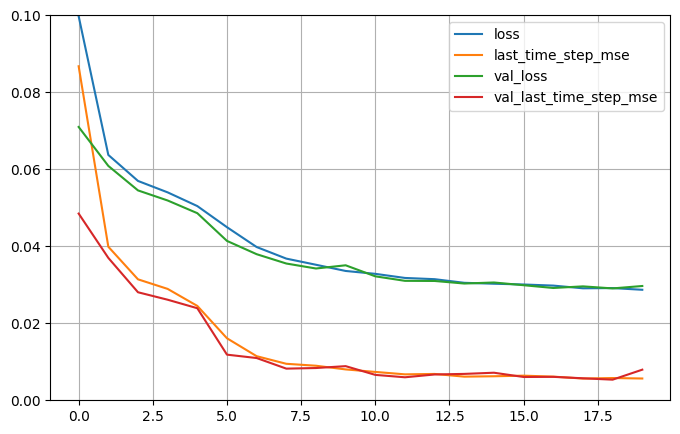

In [11]:
pd.DataFrame(train.history).plot(figsize=(8,5))
plt.grid(True)
plt.ylim(0,0.1)
plt.show()

### 4. Evaluate

In [12]:
model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.0301 - last_time_step_mse: 0.0080


[0.030130410566926003, 0.008034170605242252]

### 5. Predict

In [13]:
y_pred = model.predict(x_test,)
y_test.shape, y_pred.shape

32/32 [==============================] - 0s 1ms/step


((1000, 30, 10), (1000, 30, 10))

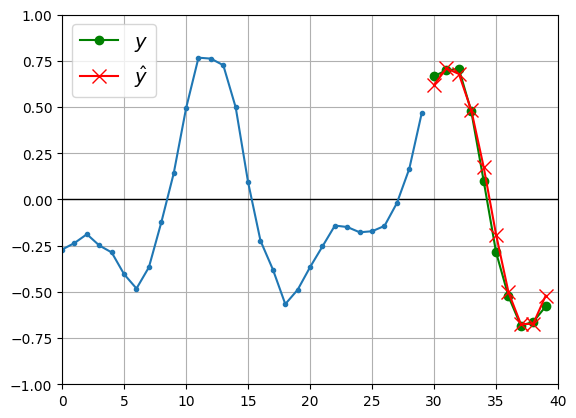

In [ ]:
i = 0
plot_seq(x_test[i,:,0], y_test[i,-1], y_pred[i,-1])

> ### Data generated like before
## GRU Cell
### 1. Build Model

In [14]:
np.random.seed(1)
tf.random.set_seed(1)

+ time_distributed: (1+20)*10 (still like dense)

In [15]:
model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]), 
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 20)          1380      
                                                                 
 gru_1 (GRU)                 (None, None, 20)          2520      
                                                                 
 time_distributed_1 (TimeDis  (None, None, 10)         210       
 tributed)                                                       
                                                                 
Total params: 4,110
Trainable params: 4,110
Non-trainable params: 0
_________________________________________________________________


### 2. Compile

In [16]:
def last_time_step_mse(y_true, y_pred):
    return keras.metrics.mean_squared_error(y_true[:,-1], y_pred[:,-1])
model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=.01),
              metrics=[last_time_step_mse])

### 3. Train 

In [17]:
train = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
94/94 [==============================] - 3s 15ms/step - loss: 0.1014 - last_time_step_mse: 0.0952 - val_loss: 0.0853 - val_last_time_step_mse: 0.0761
Epoch 2/20
94/94 [==============================] - 1s 14ms/step - loss: 0.0751 - last_time_step_mse: 0.0596 - val_loss: 0.0714 - val_last_time_step_mse: 0.0514
Epoch 3/20
94/94 [==============================] - 1s 6ms/step - loss: 0.0629 - last_time_step_mse: 0.0407 - val_loss: 0.0587 - val_last_time_step_mse: 0.0353
Epoch 4/20
94/94 [==============================] - 1s 12ms/step - loss: 0.0533 - last_time_step_mse: 0.0278 - val_loss: 0.0480 - val_last_time_step_mse: 0.0213
Epoch 5/20
94/94 [==============================] - 1s 6ms/step - loss: 0.0443 - last_time_step_mse: 0.0173 - val_loss: 0.0456 - val_last_time_step_mse: 0.0205
Epoch 6/20
94/94 [==============================] - 1s 6ms/step - loss: 0.0406 - last_time_step_mse: 0.0142 - val_loss: 0.0402 - val_last_time_step_mse: 0.0154
Epoch 7/20
94/94 [===================

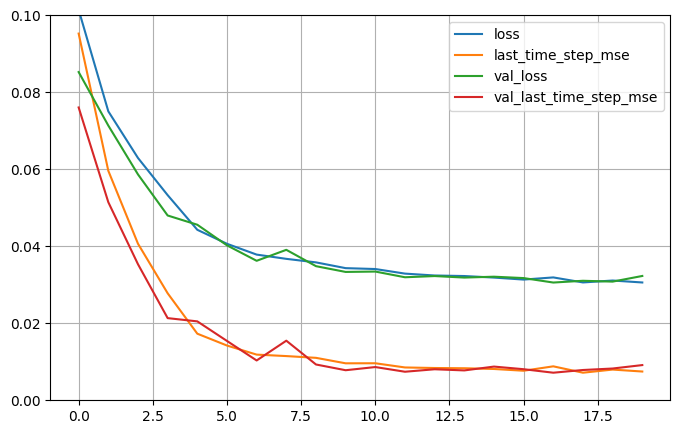

In [18]:
pd.DataFrame(train.history).plot(figsize=(8,5))
plt.grid(True)
plt.ylim(0,0.1)
plt.show()

### 4. Evaluate

In [19]:
model.evaluate(x_test, y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.0326 - last_time_step_mse: 0.0092


[0.032629095017910004, 0.009191499091684818]

### 5. Predict

In [20]:
y_pred = model.predict(x_test,)
y_test.shape, y_pred.shape

32/32 [==============================] - 0s 1ms/step


((1000, 30, 10), (1000, 30, 10))

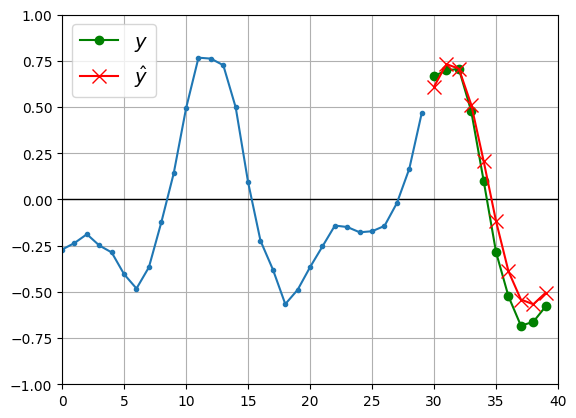

In [21]:
i = 0
plot_seq(x_test[i,:,0], y_test[i,-1], y_pred[i,-1])